In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from positioning.readwav import readwav
from positioning.create_db import create_db
from positioning.estimate import estimate

In [3]:
sns.set()

In [4]:
spec_db, ampli_db = create_db("../data/vivesound_0513")

In [5]:
print(f"spec_db.shape: {spec_db.shape}, ampli_db.shape: {ampli_db.shape}")

spec_db.shape: (81, 51, 36), ampli_db.shape: (81, 51)


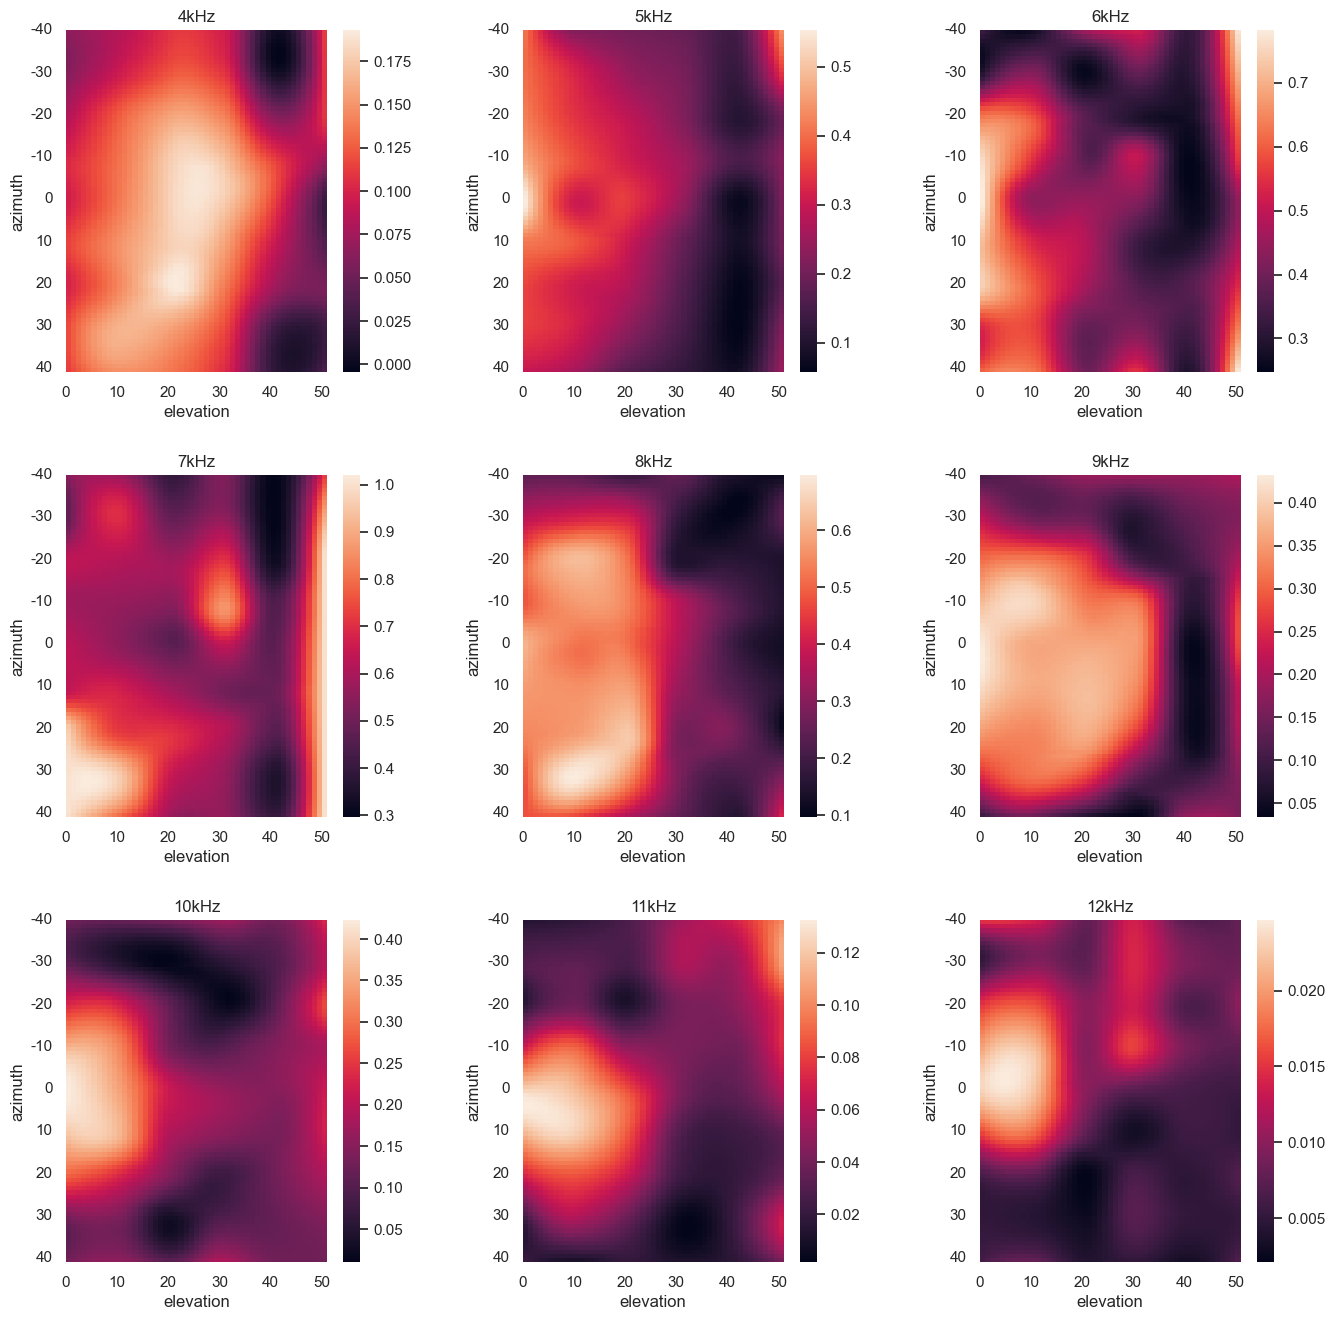

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
for i in range(3):
    for j in range(3):
        sns.heatmap(spec_db[:, :, ((i * 3) + j) * 4], ax=axes[i, j])
        axes[i][j].set_xlabel("elevation")
        axes[i][j].set_xticks(np.arange(0, 60, 10))
        axes[i][j].set_xticklabels(np.arange(0, 60, 10))
        axes[i][j].set_ylabel("azimuth")
        axes[i][j].set_yticks(np.arange(0, 81, 10))
        axes[i][j].set_yticklabels(np.arange(-40, 50, 10))
        axes[i][j].set_title(f"{(i*3)+(j) + 4}kHz")

<Axes: >

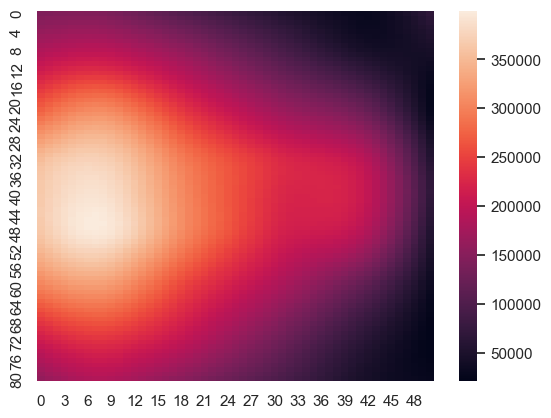

In [7]:
sns.heatmap(ampli_db)

In [8]:
test_wav = readwav("../data/vivesound_0614/test1.wav")
est_pos = estimate(spec_db, ampli_db, test_wav)

In [9]:
print(est_pos)

[-0.22788705  1.29241168  1.66867532]


In [10]:
true_poses = pd.read_csv("../data/vivesound_0614/true_positions.csv").values[:, 0:3]
true_poses

array([[-0.2149,  1.0525,  1.6218],
       [ 0.2497,  1.0482,  1.6229],
       [ 0.2523,  1.0434,  1.5334],
       [-0.4294,  1.0255,  1.528 ],
       [-0.0082,  1.2317,  1.2315],
       [-0.233 ,  1.666 ,  1.2319],
       [ 0.4514,  0.7841,  1.3436],
       [-0.5441,  1.1785,  1.0908],
       [-0.5219,  1.9388,  1.0977],
       [-0.6911,  1.795 ,  1.0894]])

各点ごとに一発ずつ測位


In [11]:
for i in range(10):
    test = readwav(f"../data/vivesound_0614/test{i+1}.wav")
    est_pos = estimate(spec_db, ampli_db, test)
    # 誤差を求める
    error = np.sqrt(np.sum((est_pos - true_poses[i]) ** 2))
    print(f"test{i+1}")
    print(f"真値: {true_poses[i]}")
    print(f"推定位置: {est_pos}")
    print(f"誤差: {error}")

test1
真値: [-0.2149  1.0525  1.6218]
推定位置: [-0.22788705  1.29241168  1.66867532]
誤差: 0.2447929204237933
test2
真値: [0.2497 1.0482 1.6229]
推定位置: [0.34238083 1.27778266 1.6168588 ]
誤差: 0.24765789442609729
test3
真値: [0.2523 1.0434 1.5334]
推定位置: [0.22075211 1.2519474  1.62003528]
誤差: 0.22801964728146643
test4
真値: [-0.4294  1.0255  1.528 ]
推定位置: [-0.74918472  1.06994666  1.34998551]
誤差: 0.3686826979374083
test5
真値: [-0.0082  1.2317  1.2315]
推定位置: [-0.02714121  1.55491913  1.3022917 ]
誤差: 0.33142245388051517
test6
真値: [-0.233   1.666   1.2319]
推定位置: [-0.32219062  1.65752703  1.5486433 ]
誤差: 0.32917028537118315
test7
真値: [0.4514 0.7841 1.3436]
推定位置: [0.42507548 1.00141507 1.48436324]
誤差: 0.26025585736025525
test8
真値: [-0.5441  1.1785  1.0908]
推定位置: [-0.68567918  1.23699799  1.        ]
誤差: 0.17807672772409117
test9
真値: [-0.5219  1.9388  1.0977]
推定位置: [0.64063305 2.56943883 1.61136175]
誤差: 1.418815290248158
test10
真値: [-0.6911  1.795   1.0894]
推定位置: [-0.98998191  1.9429489   1.        ]
誤差: 0.34

各点ごとに 100 発測位、点ごとの cdf


In [12]:
errors = []
for i in range(10):
    test = readwav(f"../data/vivesound_0614/test{i+1}.wav")
    errors.append([])
    for j in range(100):
        est_pos = estimate(spec_db, ampli_db, test[48000 * j :])
        # 誤差を求める
        error = np.sqrt(np.sum((est_pos - true_poses[i]) ** 2))
        errors[i].append(error)

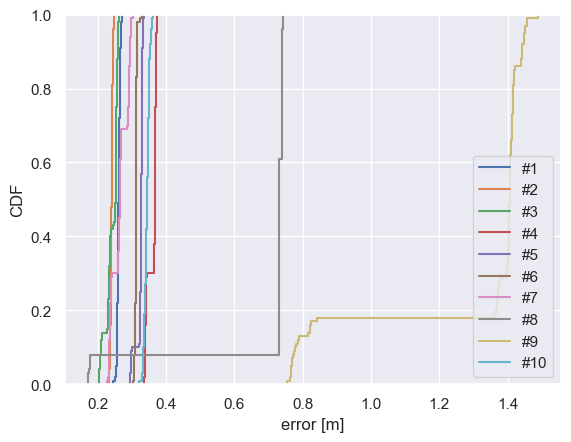

In [13]:
fig, ax = plt.subplots()
for i, err in enumerate(errors):
    sns.ecdfplot(err, ax=ax, label=f"#{i+1}")
plt.legend()
ax.set_xlabel("error [m]")
ax.set_ylabel("CDF")
plt.show()

点 9 だけ明らかに変なので角度推定、測距の面で確認してみる


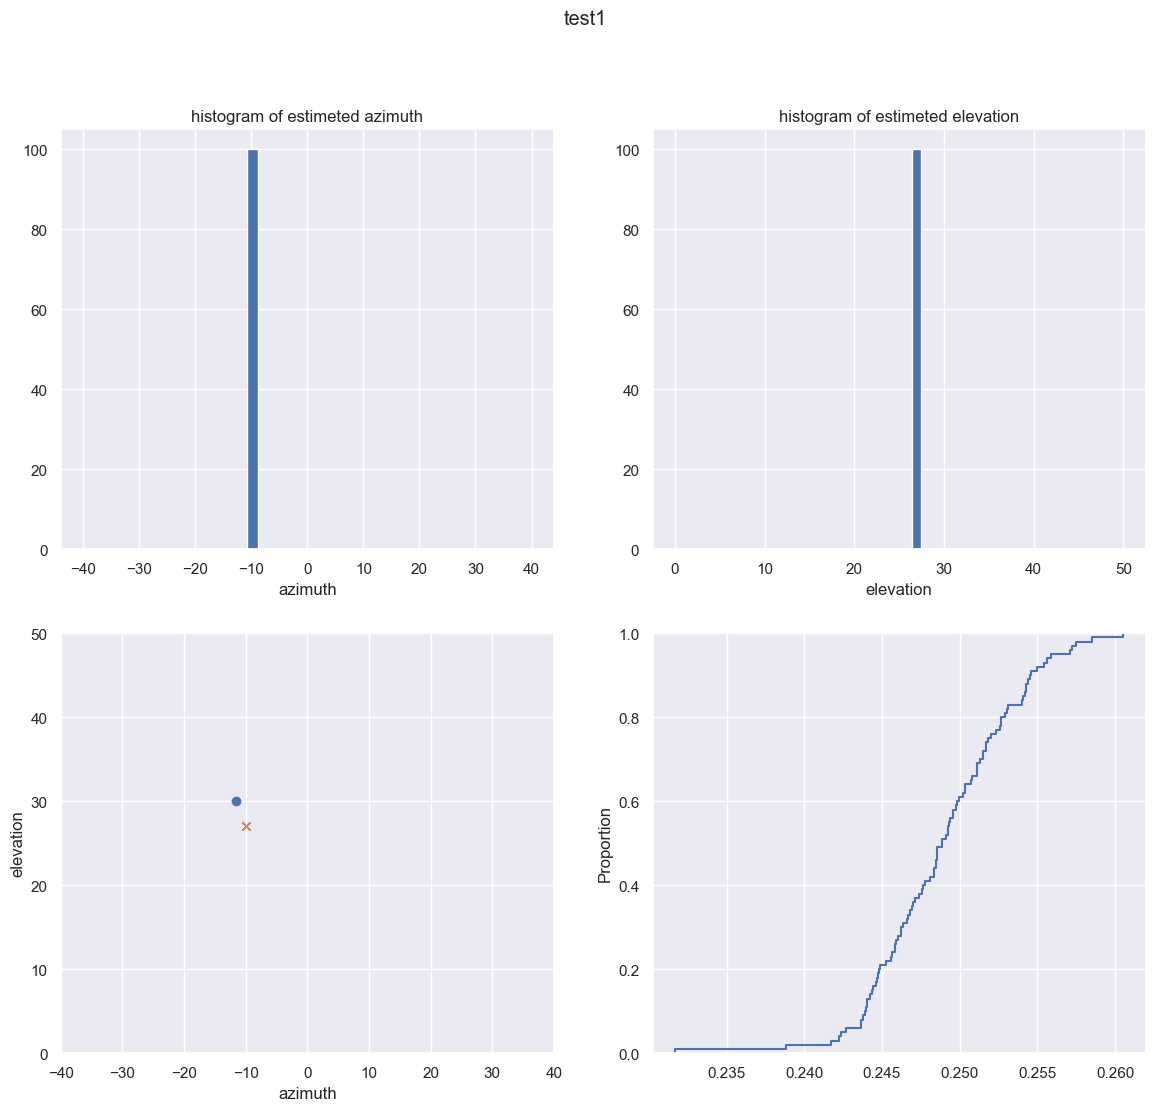

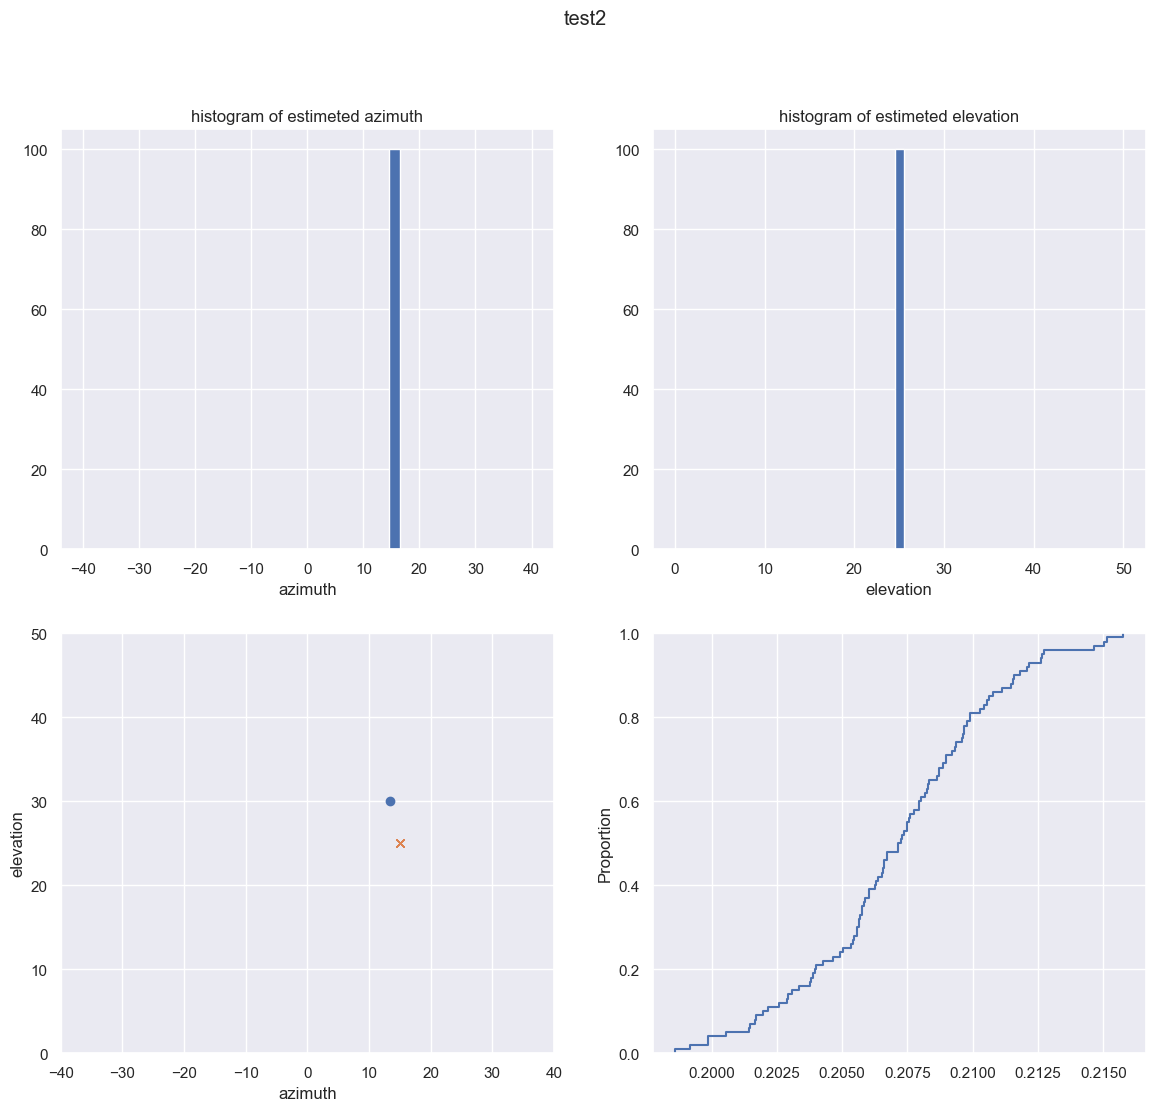

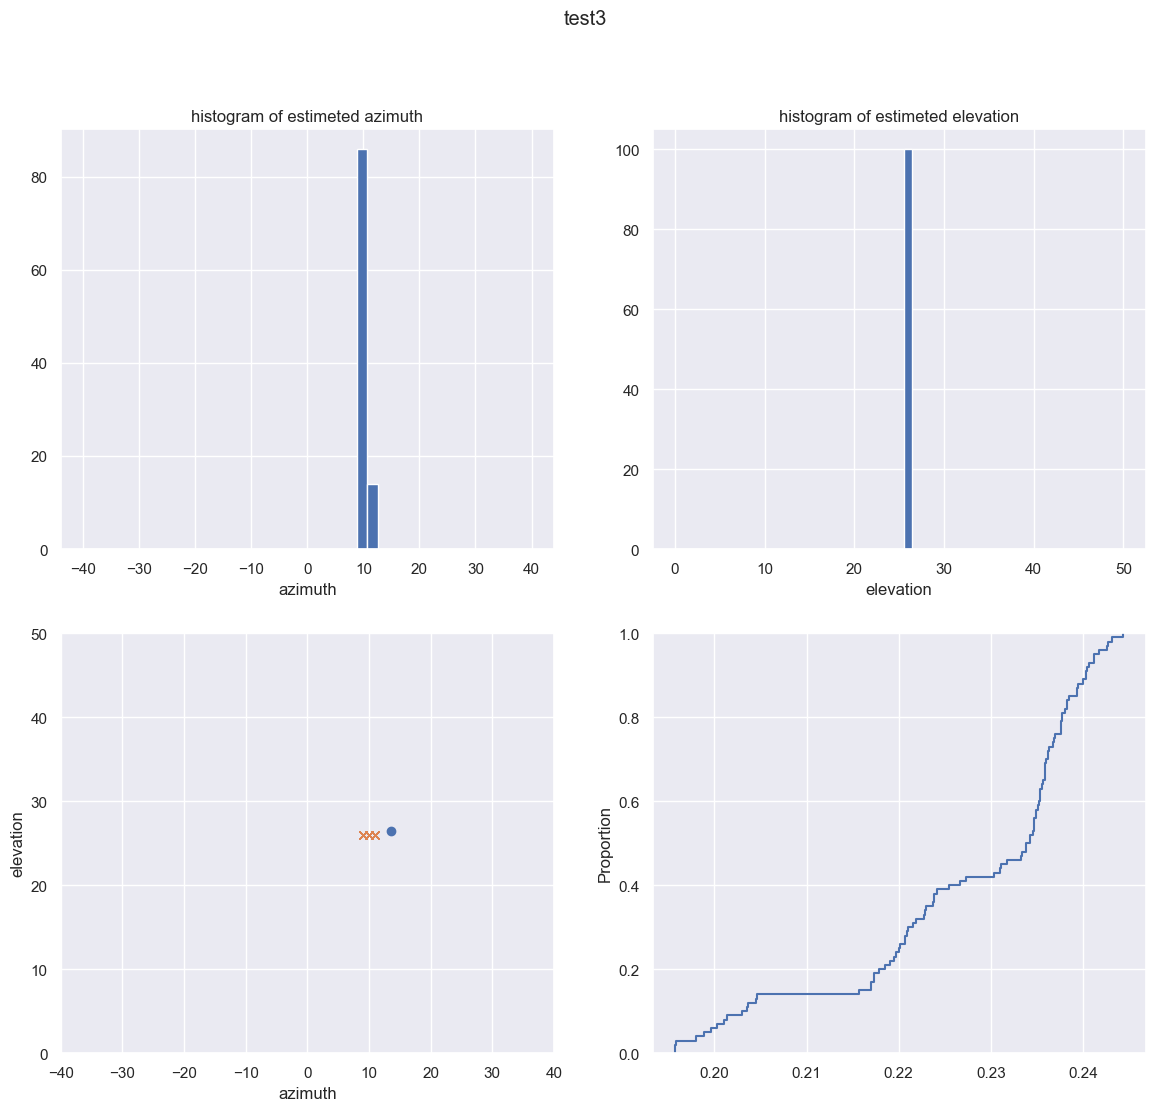

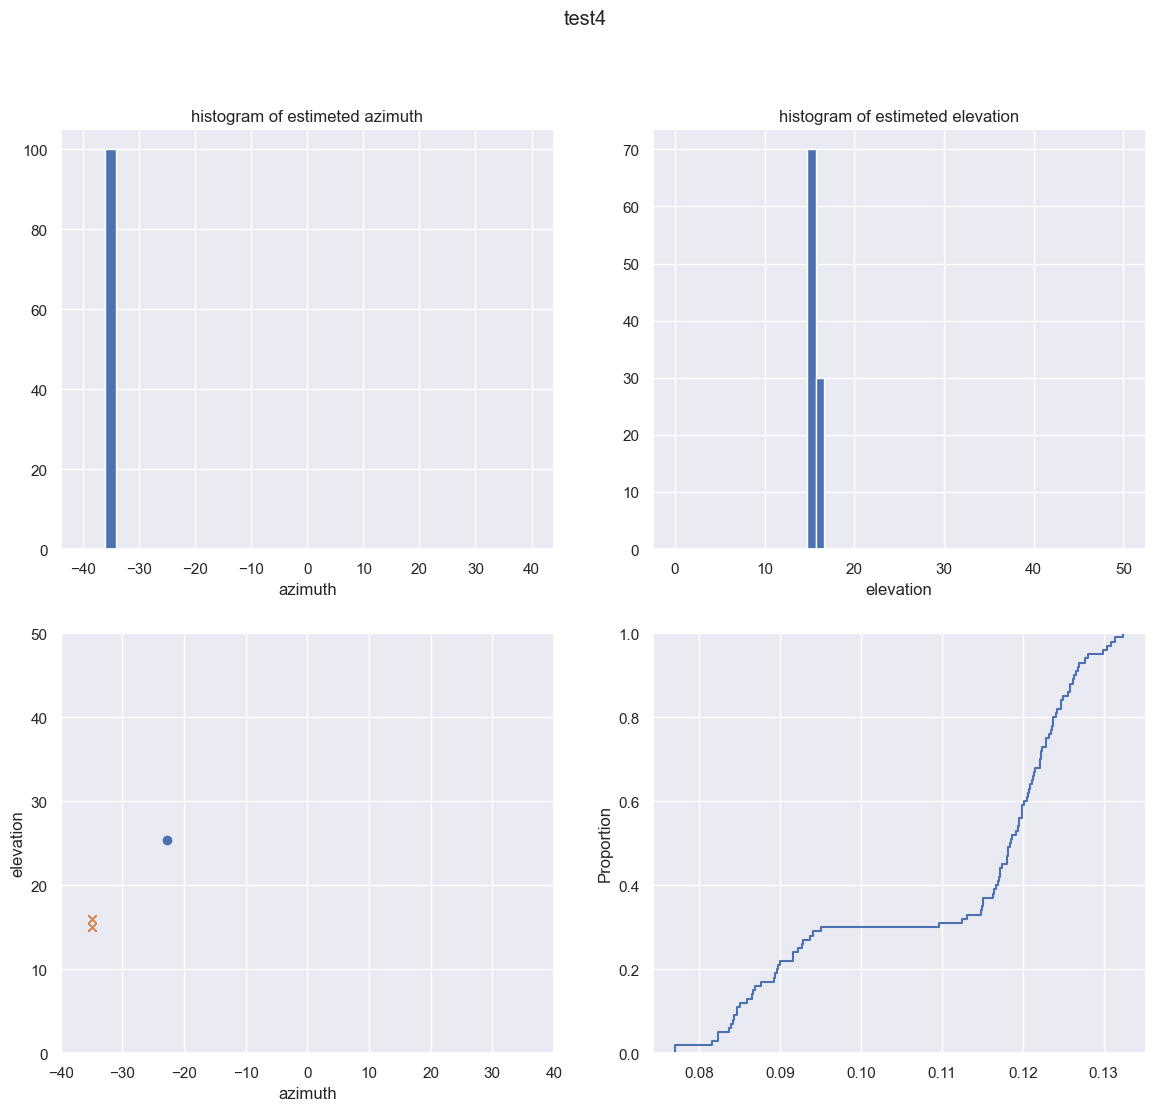

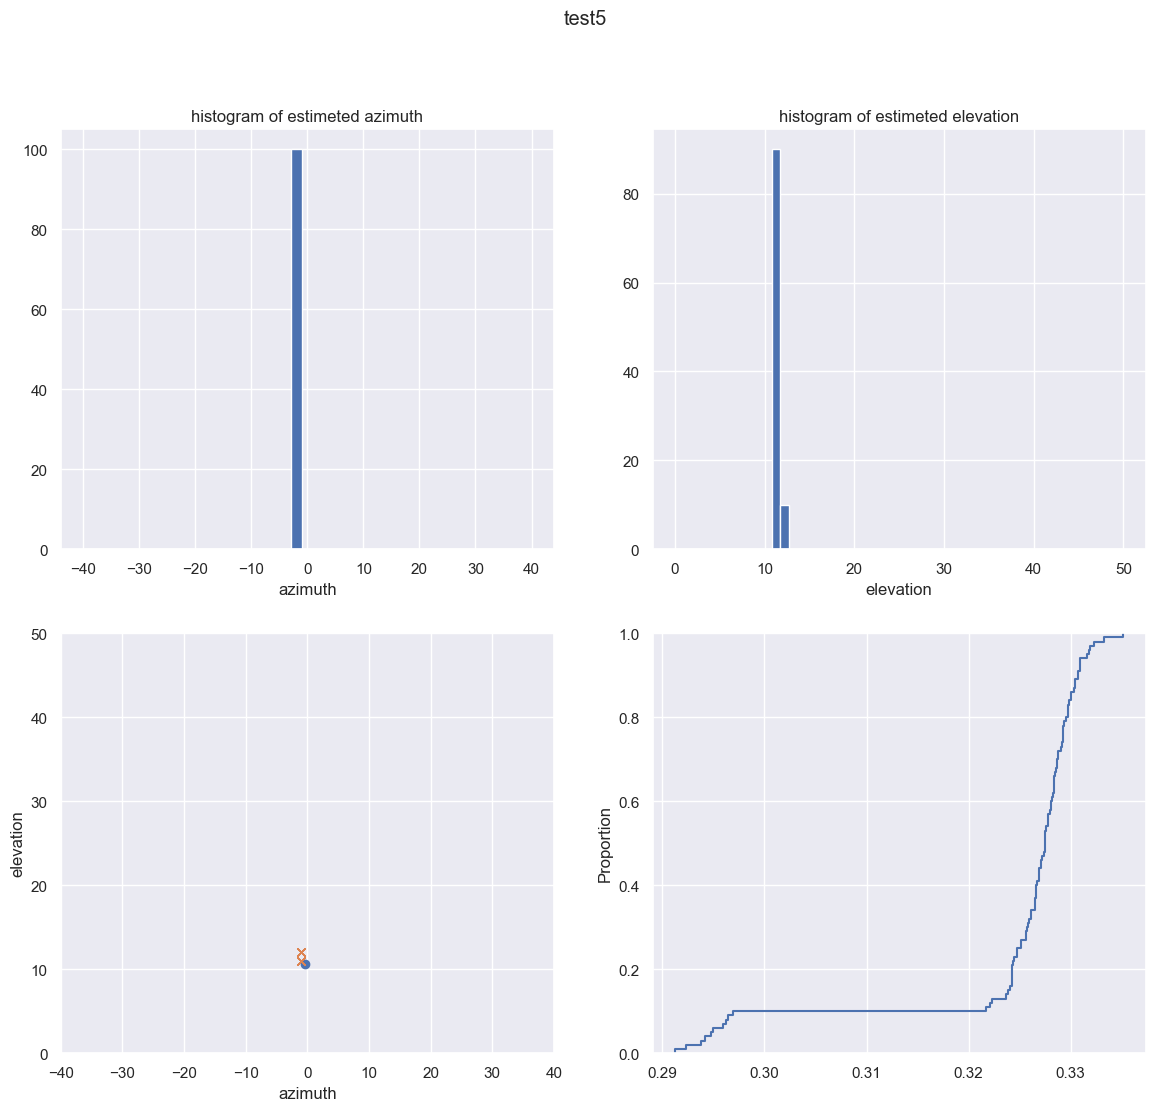

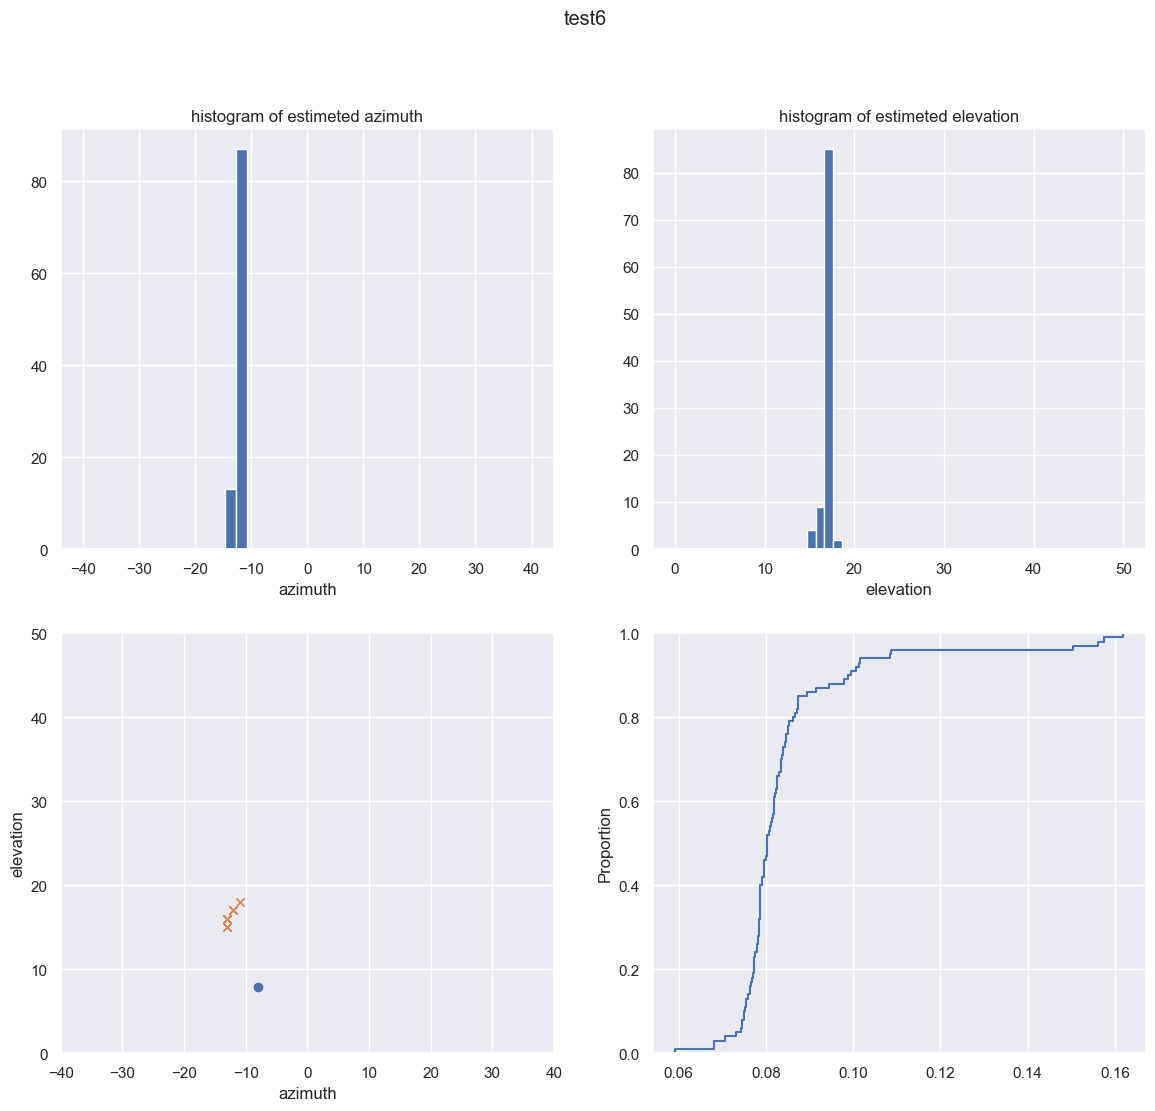

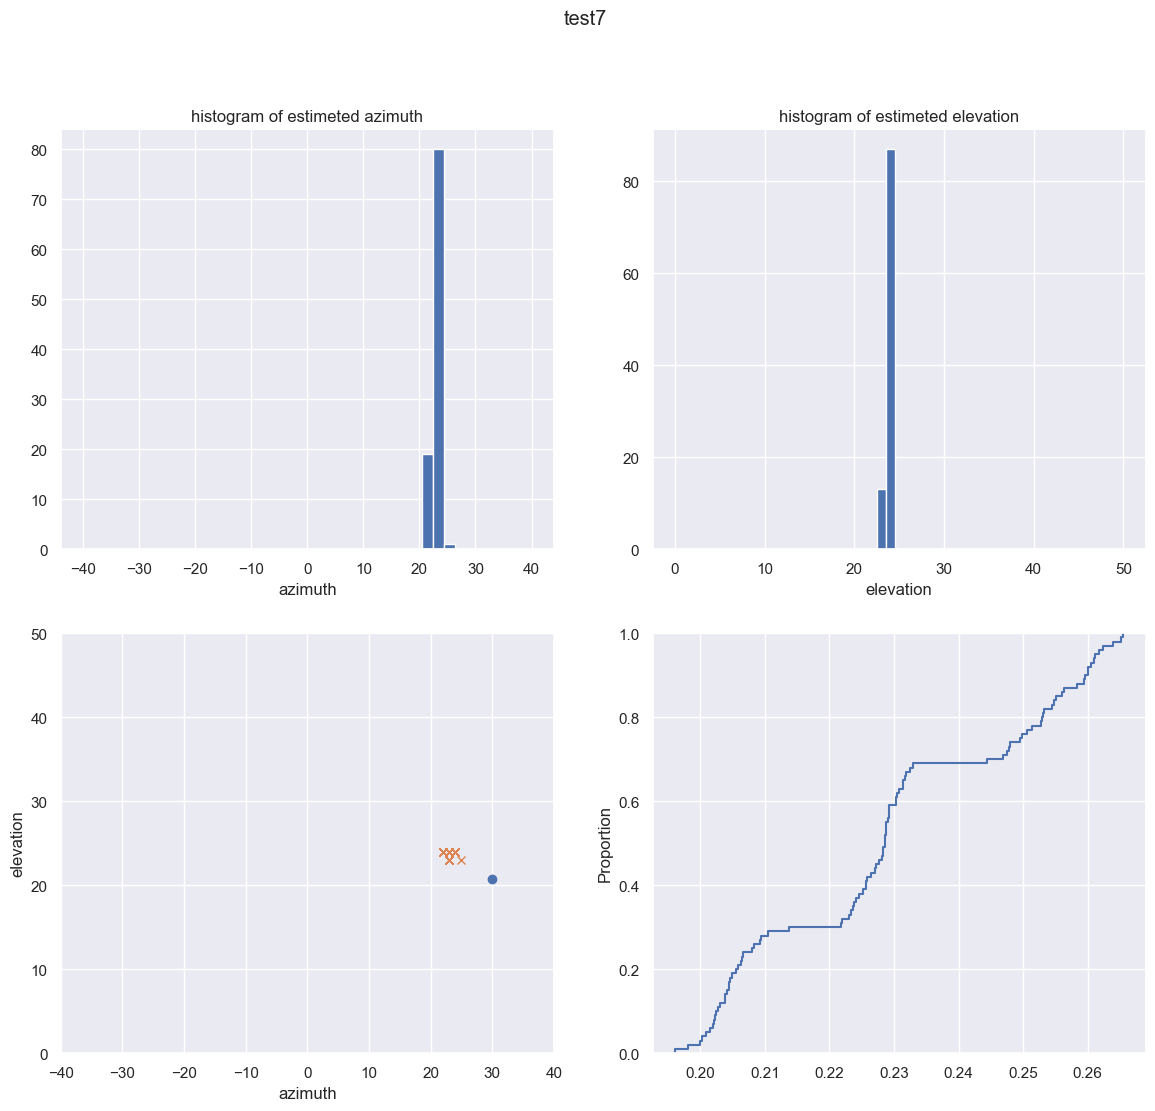

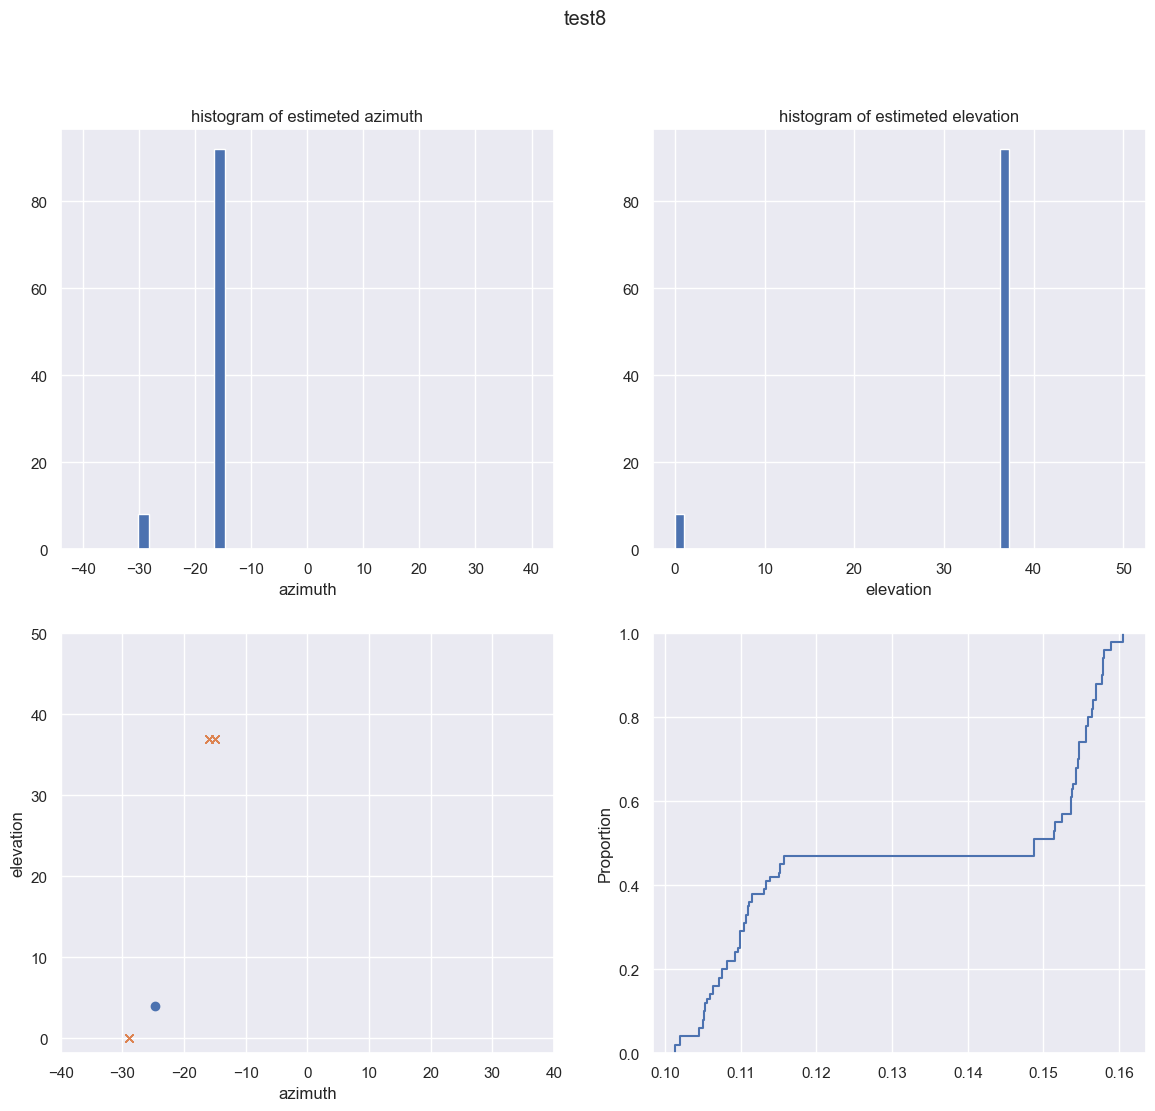

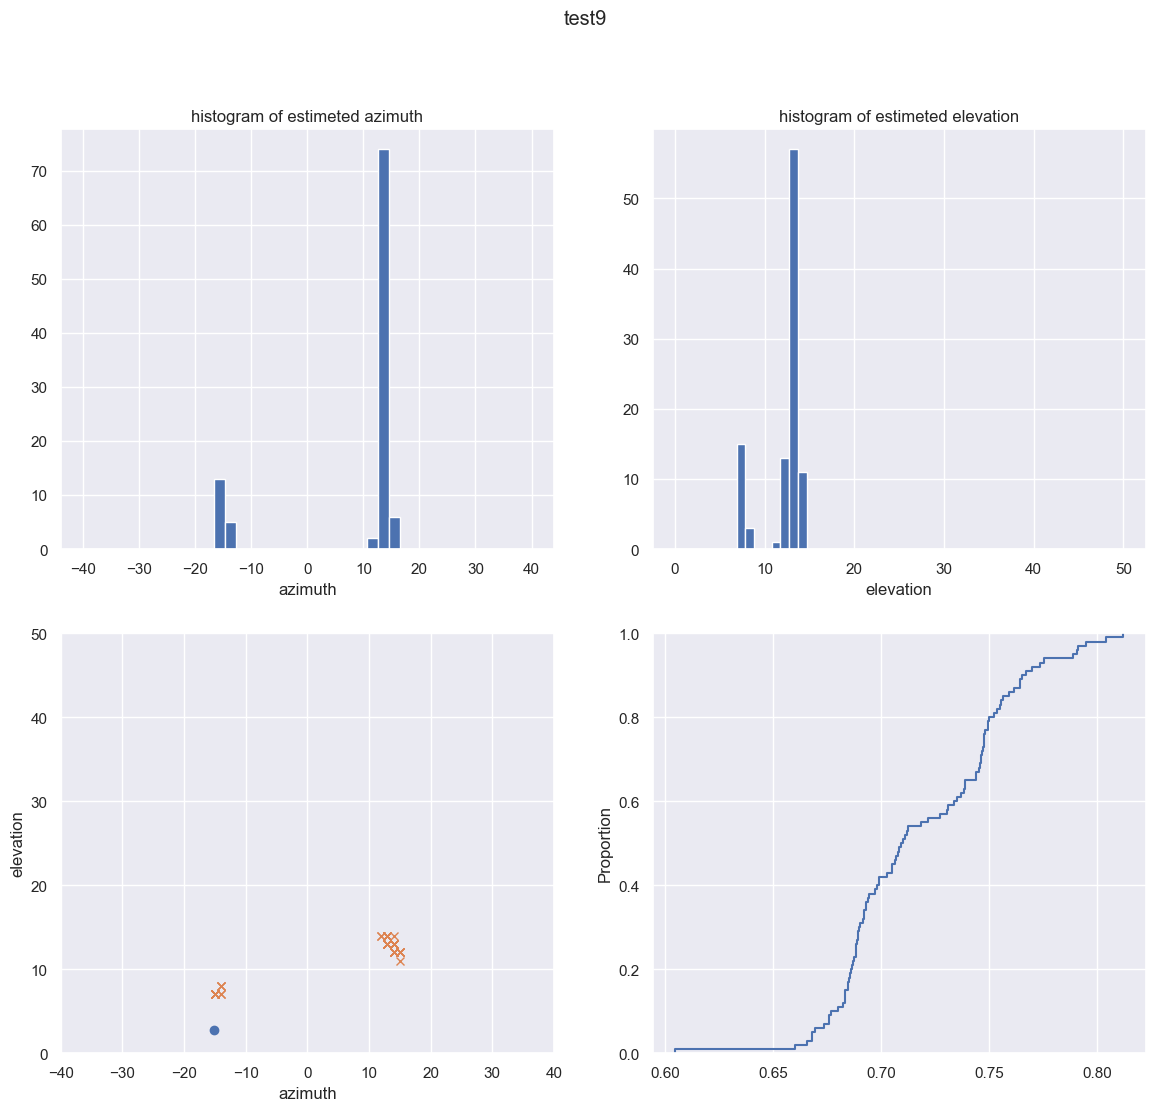

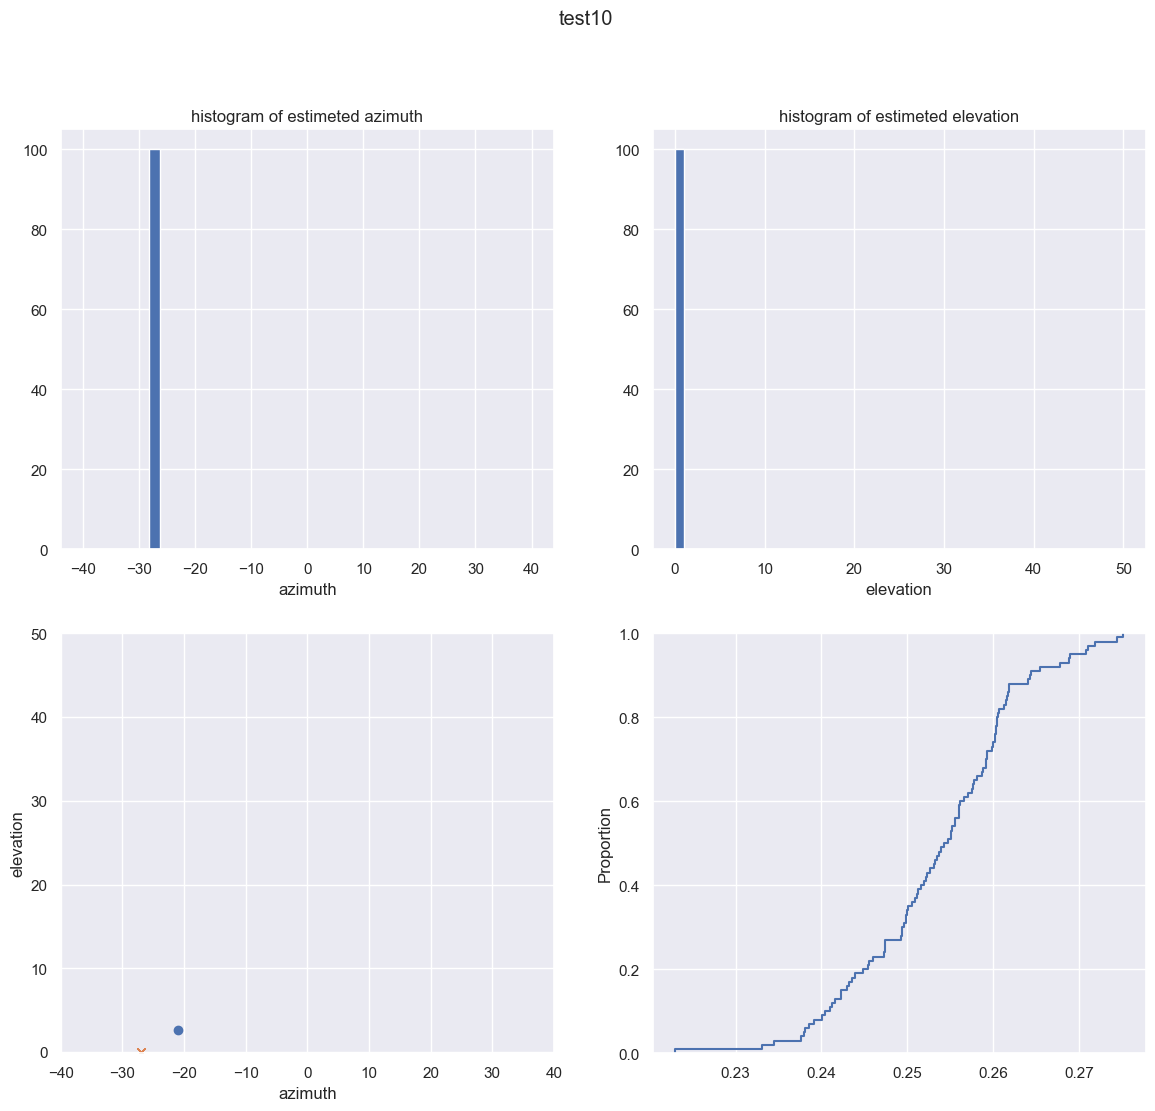

In [14]:
true_poses = pd.read_csv("../data/vivesound_0614/true_positions.csv")
for i in range(10):
    test = readwav(f"../data/vivesound_0614/test{i+1}.wav")
    true_degs = true_poses.loc[true_poses.index[i], ["azimuth", "elevation"]].values
    true_distance = true_poses.loc[true_poses.index[i], "distance"]
    est_polars = np.empty((0, 3))
    for j in range(100):
        est_polar = estimate(
            spec_db, ampli_db, test[48000 * j : 48000 * (j + 2)], "polar"
        )
        est_polars = np.vstack([est_polars, est_polar])
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f"test{i+1}")
    azimuth = np.arange(-40, 41, 10)
    elevation = np.arange(0, 51, 10)
    axes[0][0].hist(est_polars[:, 0], bins=41, range=(-40, 40))
    axes[0][0].set_xlabel("azimuth")
    axes[0][0].set_title("histogram of estimeted azimuth")
    axes[0][1].hist(est_polars[:, 1], bins=51, range=(0, 50))
    axes[0][1].set_xlabel("elevation")
    axes[0][1].set_title("histogram of estimeted elevation")
    axes[1][0].plot(true_degs[0], true_degs[1], "o", label="true")
    axes[1][0].plot(est_polars[:, 0], est_polars[:, 1], "x", label="estimate")
    axes[1][0].set_xticks(azimuth)
    axes[1][0].set_yticks(elevation)
    axes[1][0].set_xlabel("azimuth")
    axes[1][0].set_ylabel("elevation")
    # sns.jointplot(x=est_polars[:, 0], y=est_polars[:, 1])
    dist_errors = np.abs(est_polars[:, 2] - true_distance)
    sns.ecdfplot(dist_errors, ax=axes[1][1], label="distance error")